\section*{2 Linear and Quadratic Classifiers}

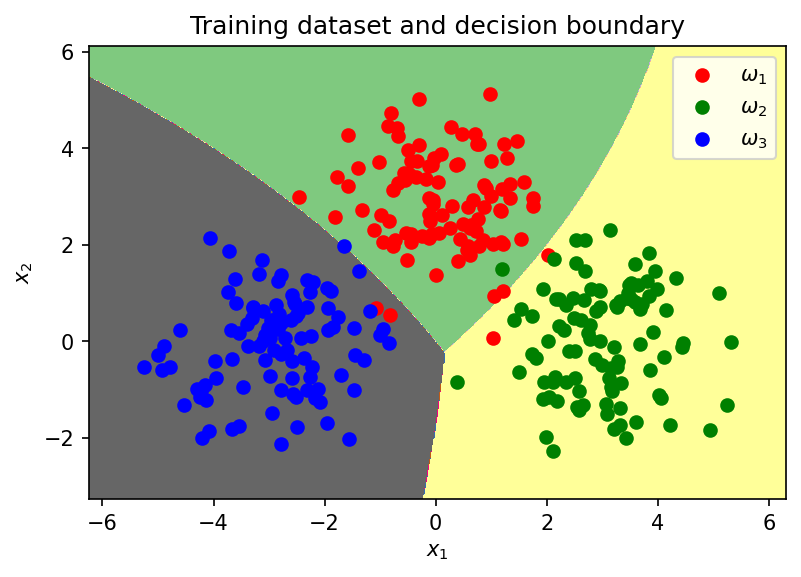

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB

plot_step = 0.02
plot_colors = "rgbycykw"

def generate(mean, cov, n):
    return np.random.multivariate_normal(mean, cov, n)

def mahalanobis(x, mean, cov):
    return np.matmul(np.matmul(np.transpose(x - mean), 
                               np.linalg.inv(cov)), x - mean)

def g(x, mean, cov, prior):
    return (- 0.5 * mahalanobis(x, mean, cov) 
            - 0.5 * len(mean) * np.log(2 * np.pi) 
            - 0.5 * np.log(np.linalg.det(cov)) 
            + np.log(prior))

def plotAll(title, X_tr, y_tr, discriminant=None):

    classes, counts = np.unique(y_tr, return_counts=True)
    idx = classes.argsort()
    classes = classes[idx]
    counts = counts[idx]
    
    n_classes = len(classes)
    sizes = counts.astype(int)
    
    # Train
    x_1 = np.split(X_tr.T[0], np.cumsum(sizes)[:-1])
    x_2 = np.split(X_tr.T[1], np.cumsum(sizes)[:-1])
    
    priors_l = sizes / np.sum(sizes)
    means_l = [np.mean(cluster, axis=0) 
               for cluster in np.split((X_tr), np.cumsum(sizes)[:-1])]
    covs_l = [np.cov(x_1[i], x_2[i]) for i in range(n_classes)]
    
    def predict(X):
        post = []
        for x in X:
            post.append([discriminant(x, means_l[i], covs_l[i], priors_l[i]) 
                         for i in range(n_classes)])
        return np.argmax(post, axis=1)
                         
    x_min, x_max = np.min(X_tr.T[0]) - 1, np.max(X_tr.T[0]) + 1
    y_min, y_max = np.min(X_tr.T[1]) - 1, np.max(X_tr.T[1]) + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    
    # Plot the decision boundary
    if discriminant != None:  
        # Use custom classifier
        Z = predict(np.c_[xx.ravel(), yy.ravel()])
    else:
        # Use built-in classifier
        gnb = GaussianNB()
        Z = gnb.fit(X_tr, y_tr).predict(np.c_[xx.ravel(), yy.ravel()])
        
    Z = Z.reshape(xx.shape)
    fig, ax = plt.subplots(dpi=150)
    cs = ax.contourf(xx, yy, Z, cmap=plt.cm.Accent)
    
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y_tr == i)
        ax.scatter(X_tr[idx, 0], X_tr[idx, 1], c=color, 
                    label=r'$\omega_{' + str(i+1) + '}$',
                    cmap=plt.cm.Paired)
    
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_title(title)
    ax.legend()
    plt.show()
    
n_pts = 100 * np.ones(3, dtype=int)  # Same number of data points for each class
means = [[0, 3], [3, 0], [-3, 0]]
covs = [np.eye(2) for i in range(3)]  # Same covariance for each class

X_tr = []
for i, mean in enumerate(means):
    cluster = generate(mean, covs[i], n_pts[i])
    X_tr.extend(cluster)
X_tr = np.array(X_tr)    
y_tr = np.ravel([i*np.ones(j) for i, j in enumerate(n_pts)])

plotAll("Training dataset and decision boundary", X_tr, y_tr, g)

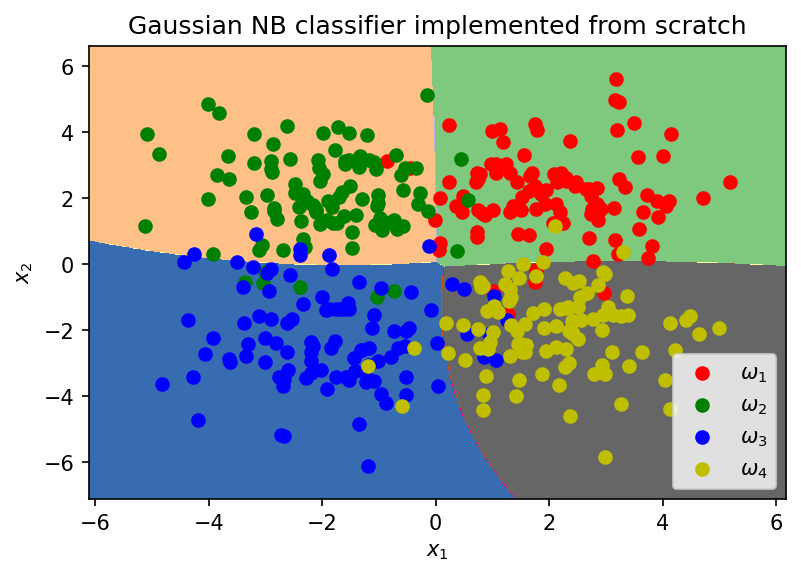

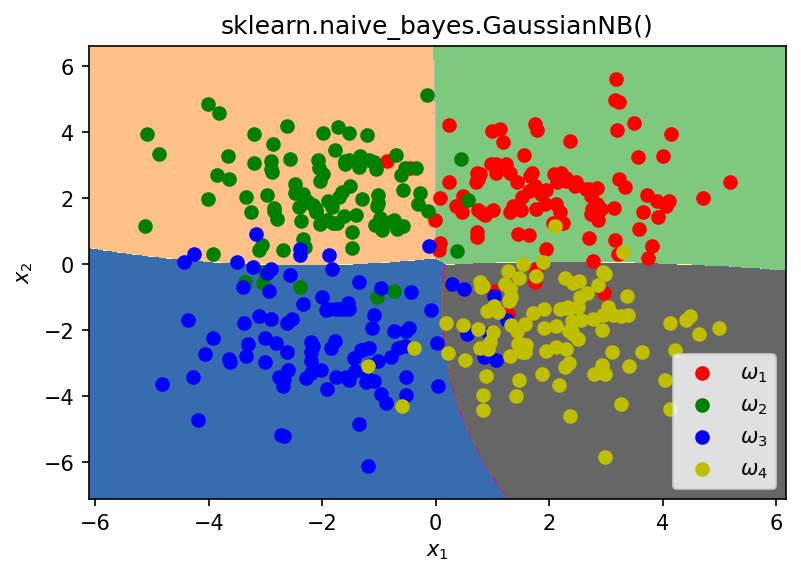

In [2]:
def posterior(x, mean, cov, prior):
    likelihood = (np.power(np.sqrt((np.linalg.det(cov))), -1) 
                  * np.power(2 * np.pi, - .5 * len(mean)) 
                  * np.exp(-.5 * mahalanobis(x, mean, cov)))
    return likelihood * prior

n_pts = 100 * np.ones(4, dtype=int)
means = [[2, 2], [-2, 2], [-2, -2], [2, -2]]
covs = [1.5 * np.eye(2) for i in range(4)]

X_tr = []
for i, mean in enumerate(means):
    cluster = generate(mean, covs[i], n_pts[i])
    X_tr.extend(cluster)
X_tr = np.array(X_tr)    
y_tr = np.ravel([i*np.ones(j) for i, j in enumerate(n_pts)])

plotAll("Gaussian NB classifier implemented from scratch", X_tr, y_tr, posterior)
plotAll("sklearn.naive_bayes.GaussianNB()", X_tr, y_tr)

\newpage
\section*{2 Misc Code}

I will approach this problem as if we are throwing a rock at a segmented line and if the rock hits the $i$th segment we pick ourselves the number $i$. Obviously, ratio of the length of the $i$th segment to the total length of the line is the probability of picking $i$. 

The function \texttt{np.random.uniform()} will be the equivalent of the rock in this problem, in that it will hit a point somewhere in $[0, 1)$. So, we need a line whose length is unity and whose segments will relate to $p_i$s. Cumulative sum of the given probability distribution accomplishes this: $[0, p_1, p_1+p_2, \cdots, p_1+\cdots+p_N ]$. 

If the rock, lets say, hits the second segment, that is $p_1\le$\texttt{np.random.uniform()}$<p_1+p_2$, we will pick the number 2. Following function \texttt{sample(M, p)} implements this approach:

In [3]:
def sample(M, p):
    
    cum_p = np.cumsum(p)
    cum_p = np.insert(cum_p, 0, 0)
    
    out = []
    for j in range(M):
        number = np.random.uniform()
        for i in range(len(p)):
            if cum_p[i] <= number < cum_p[i+1]:
                out.append(i+1)
                
    numbers, counts = np.unique(out, return_counts=True)
    return out, dict(zip(numbers, counts))

outs, freqs = sample(1000, [.05, .15, .3, .5])
print(freqs)

{1: 47, 2: 158, 3: 290, 4: 505}
